In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
#from nmf_compressed.structured_nmf import structured_randomized_bppnmf
from scipy import misc
from skimage import color
from sklearn.externals import joblib
import xgboost as xgb
import glob
import seaborn as sns
import pandas as pd
import os
sns.set(style="white", palette="muted", color_codes=True)

/home/aremirata/.conda/envs/claims/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression

In [3]:
from sklearn.metrics import auc, roc_curve, recall_score
from sklearn.model_selection import StratifiedKFold
from imblearn.pipeline import make_pipeline
from scipy import interp

In [4]:
labelpath = '/home/aremirata/thesis/kaggle/trainLabels.csv'
df_labels = pd.read_csv(labelpath)

# Create A Big Matrix For Training Images

## Store Each Of The Training Images in DataFrames

In [5]:
resize_train_images = glob.glob('/home/aremirata/thesis/kaggle/train_resize/*')

In [6]:
index = range(0, len(resize_train_images))
df_image = pd.DataFrame(index=index, columns=['image','actual_image'])
for i in range(len(resize_train_images)):
    df_image['image'][i] = resize_train_images[i].split('/')[-1][0:-5]
    df_image['actual_image'][i] = misc.imread(resize_train_images[i])

In [7]:
df_image.head()

,image,actual_image
0,1914_right,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
1,14947_right,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
2,30696_right,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
3,40534_right,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
4,2516_left,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


In [8]:
df_image['image_resize'] = df_image['actual_image'].apply(lambda x: color.rgb2gray(x))

In [9]:
train_df = pd.merge(df_image, df_labels, on='image', how='inner')

In [10]:
train_df.head()

,image,actual_image,image_resize,level
0,1914_right,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
1,14947_right,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
2,30696_right,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
3,40534_right,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
4,2516_left,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0


In [11]:
len(train_df), len(df_image), len(df_labels)

(28530, 28530, 35126)

# Work on Test Images

In [12]:
testlabelpath = '/home/aremirata/thesis/kaggle/retinopathy_solution.csv'
test_labels = pd.read_csv(testlabelpath)

In [13]:
test_labels.head()

,image,level,Usage
0,1_left,0,Private
1,1_right,0,Private
2,2_left,0,Public
3,2_right,0,Public
4,3_left,2,Private


In [14]:
resize_test_images = glob.glob('/home/aremirata/thesis/kaggle/test_resize/*')

In [15]:
index = range(0, len(resize_test_images))
df_test_image = pd.DataFrame(index=index, columns=['image','actual_image'])
for i in range(len(resize_test_images)):
    df_test_image['image'][i] = resize_test_images[i].split('/')[-1][0:-5]
    df_test_image['actual_image'][i] = misc.imread(resize_test_images[i])

In [16]:
df_test_image.head()

,image,actual_image
0,39168_right,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
1,37877_left,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
2,35528_right,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
3,32775_right,"[[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], ..."
4,1704_right,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


In [17]:
df_test_image['image_resize'] = df_test_image['actual_image'].apply(lambda x: color.rgb2gray(x))

In [18]:
test_df = pd.merge(df_test_image, test_labels, on='image', how='inner')

In [19]:
test_df.head()

,image,actual_image,image_resize,level,Usage
0,39168_right,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2,Private
1,37877_left,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,Private
2,35528_right,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,Private
3,32775_right,"[[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], ...","[[0.00392156862745, 0.00392156862745, 0.003921...",2,Private
4,1704_right,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,Private


# Apply Compressed NMF to Training Set

In [20]:
train_df['image_flatten'] = train_df['image_resize'].apply(lambda x: x.ravel())

In [21]:
train_df.head()

,image,actual_image,image_resize,level,image_flatten
0,1914_right,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,14947_right,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,30696_right,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,40534_right,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,2516_left,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [22]:
training_set = np.stack(train_df['image_flatten'].as_matrix(),axis=0)

In [23]:
training_set

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [24]:
training_set.shape

(28530, 65536)

In [54]:
y_train = np.stack(train_df['level'].as_matrix(),axis=0)

In [55]:
y_train

array([0, 0, 0, ..., 0, 0, 0])

## Check Sparsity of Training Data

In [27]:
sparsity_value =  np.count_nonzero(training_set)/np.prod(training_set.shape)

In [28]:
sparsity_value

0.71280474684508355

The data above can be considered as nonsparse since there are more nonzero entries.

# Uncompressed NMF

In [ ]:
from nmf_compressed.structured_nmf import structured_randomized_bppnmf
from numpy.linalg import norm, solve
from ntf_cython.nmf import nmf

In [26]:
%time W, H, n_iters, rel_errors = nmf(training_set, n_components=300, max_iter=200, random_state=42)

CPU times: user 2d 9h 2min 23s, sys: 7h 18min 21s, total: 2d 16h 20min 44s
Wall time: 9h 15min 26s


In [54]:
joblib.dump(W,'/home/aremirata/thesis/compressednmf/models/W_train.jl')
joblib.dump(H,'/home/aremirata/thesis/compressednmf/models/H_train.jl')
joblib.dump(n_iters,'/home/aremirata/thesis/compressednmf/models/n_iters_train.jl')
joblib.dump(rel_errors,'/home/aremirata/thesis/compressednmf/models/rel_errors_train.jl')

['/home/aremirata/thesis/compressednmf/models/rel_errors_train.jl']

In [29]:
W_train = joblib.load('/home/aremirata/thesis/compressednmf/models/W_train.jl')
H_train = joblib.load('/home/aremirata/thesis/compressednmf/models/H_train.jl')
n_iters_train = joblib.load('/home/aremirata/thesis/compressednmf/models/n_iters_train.jl')
rel_errors_train = joblib.load('/home/aremirata/thesis/compressednmf/models/rel_errors_train.jl')

/home/aremirata/.conda/envs/claims/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: The file '/home/aremirata/thesis/compressednmf/models/W_train.jl' has been generated with a joblib version less than 0.10. Please regenerate this pickle file.
  if __name__ == '__main__':
/home/aremirata/.conda/envs/claims/lib/python3.5/site-packages/ipykernel/__main__.py:2: DeprecationWarning: The file '/home/aremirata/thesis/compressednmf/models/H_train.jl' has been generated with a joblib version less than 0.10. Please regenerate this pickle file.
  from ipykernel import kernelapp as app


/home/aremirata/.conda/envs/claims/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


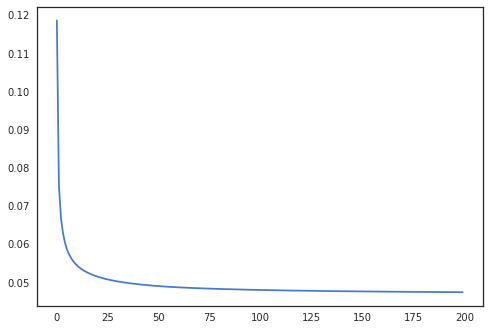

In [30]:
plt.plot(rel_errors_train)

# Apply Compressed NMF to Test Set

In [31]:
test_df['image_flatten'] = test_df['image_resize'].apply(lambda x: x.ravel())

In [32]:
test_df.head()

,image,actual_image,image_resize,level,Usage,image_flatten
0,39168_right,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2,Private,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,37877_left,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,Private,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,35528_right,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,Private,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,32775_right,"[[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], ...","[[0.00392156862745, 0.00392156862745, 0.003921...",2,Private,"[0.00392156862745, 0.00392156862745, 0.0039215..."
4,1704_right,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,Private,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [50]:
testing_set = np.stack(test_df['image_flatten'].as_matrix(),axis=0)

In [51]:
y_test = np.stack(test_df['level'].as_matrix(),axis=0)

In [56]:
np.unique(y_train)

array([0, 1, 2, 3, 4])

In [57]:
np.unique(y_test)

array([0, 1, 2, 3, 4])

# Check Sparsity of Testing Data

In [37]:
sparsity_value =  np.count_nonzero(testing_set)/np.prod(testing_set.shape)

In [38]:
sparsity_value

0.71392998372877325

The data above can be considered as nonsparse since there are more nonzero entries.

# Uncompressed NMF For Test Data

In [38]:
from nmf_compressed.structured_nmf import structured_randomized_bppnmf
from numpy.linalg import norm, solve
from ntf_cython.nmf import nmf

In [39]:
%time W_test, H_test, n_iters_test, rel_errors_testset = nmf(testing_set, n_components=300, max_iter=200, random_state=42)

CPU times: user 3d 8h 32min 37s, sys: 8h 26min 44s, total: 3d 16h 59min 22s
Wall time: 12h 45min 19s


In [57]:
joblib.dump(W_test,'/home/aremirata/thesis/compressednmf/models/W_test.jl')
joblib.dump(H_test,'/home/aremirata/thesis/compressednmf/models/H_test.jl')
joblib.dump(n_iters_test,'/home/aremirata/thesis/compressednmf/models/n_iters_test.jl')
joblib.dump(rel_errors_testset,'/home/aremirata/thesis/compressednmf/models/rel_errors_test.jl')

['/home/aremirata/thesis/compressednmf/models/rel_errors_test.jl']

In [39]:
W_test = joblib.load('/home/aremirata/thesis/compressednmf/models/W_test.jl')
H_test = joblib.load('/home/aremirata/thesis/compressednmf/models/H_test.jl')
n_iters_test = joblib.load('/home/aremirata/thesis/compressednmf/models/n_iters_test.jl')
rel_errors_test = joblib.load('/home/aremirata/thesis/compressednmf/models/rel_errors_test.jl')

/home/aremirata/.conda/envs/claims/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: The file '/home/aremirata/thesis/compressednmf/models/W_test.jl' has been generated with a joblib version less than 0.10. Please regenerate this pickle file.
  if __name__ == '__main__':
/home/aremirata/.conda/envs/claims/lib/python3.5/site-packages/ipykernel/__main__.py:2: DeprecationWarning: The file '/home/aremirata/thesis/compressednmf/models/H_test.jl' has been generated with a joblib version less than 0.10. Please regenerate this pickle file.
  from ipykernel import kernelapp as app


/home/aremirata/.conda/envs/claims/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


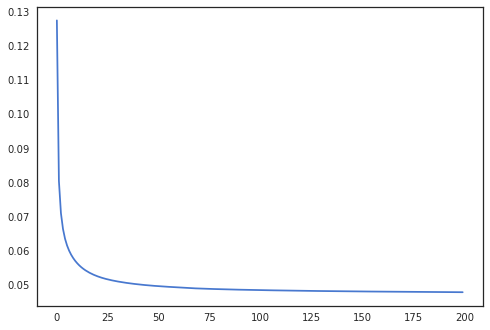

In [40]:
plt.plot(rel_errors_test)

# Apply XGBoost Classifier to the Classification Algorithm With Resampling Algorithm

In [41]:
print('Original dataset shape {}'.format(Counter(y_train)))

Original dataset shape Counter({0: 20984, 2: 4275, 1: 1940, 3: 734, 4: 597})


In [42]:
print('Original dataset shape {}'.format(Counter(y_test)))

Original dataset shape Counter({0: 36164, 2: 7195, 1: 3453, 3: 1103, 4: 1100})


In [43]:
X_train = W_train.copy()
X_test = W_test.copy()

In [44]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc

In [45]:
def build_models(X, y, classifier=None, samplers=None):
    
    """
    Train model using the given training set and validate it through the validation set.
    If plot is true, the function plots the roc curve.
    
    Parameters
    ----------
    X: 2D-array
        Contains features from the dimension reduction methods used
        for training the dataset
    y: 
        The target variable we want to predict
    """
    
    best_model = None
    best_roc = -1
    
    cv = StratifiedKFold(n_splits=3)
    
    

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    
    for train, test in cv.split(X, y):

        dtrain = xgb.DMatrix(X[train], label=y[train])
        dtest = xgb.DMatrix(X[test], label=y[test])

        n_classes = len(np.unique(y))

        param = {
            'max_depth': 3,  # the maximum depth of each tree
            'eta': 0.3,  # the training step for each iteration
            'silent': 1,  # logging mode - quiet
            'objective': 'multi:softprob',  # error evaluation for multiclass training
            'num_class': n_classes}  # the number of classes that exist in this datset

        num_round = 20  # the number of training iterations

        bst = xgb.train(param, dtrain, num_round)
        y_score = bst.predict(dtest)

        y_train = label_binarize(y[train], classes=list(np.unique(y)))
        y_test = label_binarize(y[test], classes=list(np.unique(y)))

        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute AUC
        mean_tpr /= n_classes

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


        if roc_auc["macro"] > best_roc:
            best_roc = roc_auc["macro"]
            best_model = bst
                

    mean_tpr /= cv.get_n_splits(X, y)
    mean_tpr[-1] = 1.0
    mean_auc = auc(all_fpr, mean_tpr)
    plt.plot(all_fpr, mean_tpr, linestyle='--',
             label='XGB Multilabel Classifier: (AUROC : %.3f))'% ( mean_auc), lw=2)

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k',
             label='Luck')

    # make nice plotting
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')

    plt.legend(loc="lower right")

    plt.show()
    
    return best_model

/home/aremirata/.conda/envs/claims/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


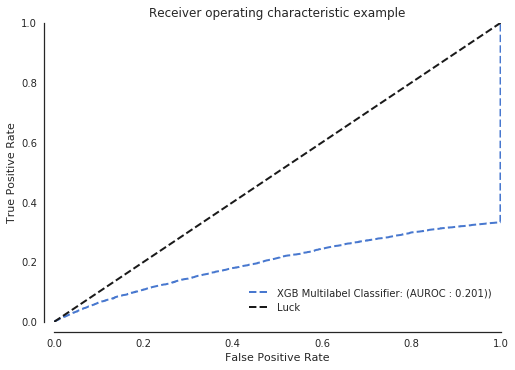

In [46]:
RANDOM_STATE = 42
xgb_model = build_models(X_train, y_train)

In [58]:
xgboost = xgb_model
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

y_score = xgboost.predict(dtest)

n_classes = len(np.unique(y_train))

y_train = label_binarize(y_train, classes=list(np.unique(y_train)))
y_test = label_binarize(y_test, classes=list(np.unique(y_test)))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
        
print("The roc auc score using {} classifier is {}".format('xgboost',roc_auc["macro"]))

The roc auc score using xgboost classifier is 0.5023923408205603


In [59]:
y_train.shape

(28530, 5)

In [60]:
y_test.shape

(49015, 5)